# Estimating Eddy Diffusivity, K_e

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
#from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

ModuleNotFoundError: No module named 'xgcm.autogenerate'

In [ ]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [ ]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

$$K_e = K_\rho (\partial_z \theta_e)^2 / (\nabla_n \theta_m)^2$$

- Term 1: $K_rho$
- Term 2: $(\partial_z \theta_e)^2$
- Term 3: $(\nabla_n \theta_m)^2$

$$K_e = K_\rho (\partial_z \theta_e)^2 / |(\nabla_n \theta_m)|^2$$

$$\widetilde{u}\widetilde{S} = \kappa(\frac{\Delta\widetilde{S}}{\Delta z})^2 / (\frac{\Delta\overline{S}}{\Delta x})$$

$\kappa = 10^{-4} \frac{m^2}{s}$

$(\frac{\Delta\widetilde{T}}{\Delta z}) = 0.025 \frac{^\circ C}{m}$, $(\frac{\Delta\widetilde{T}}{\Delta z})^2 = 6.25 x 10^{-4} \frac{^\circ C}{m}$

$(\frac{\Delta\overline{T}}{\Delta x}) = 10^{-4} \frac{^\circ C}{m}$

$\widetilde{u}\widetilde{T} = 6.25 x 10^{-4} \frac{^\circ C m}{s}$

# Functions

In [12]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [13]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [14]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    }).rename_vars({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'density'}
    }, periodic=['X'])

    return ds_gridded, grid

In [15]:
def get_grad(ds_gridded, grid, var):
    dlong = grid.diff(ds_gridded.lon, 'X')
    dlatg = grid.diff(ds_gridded.lat, 'Y', boundary='fill', fill_value=np.nan)
    
    distance_1deg_equator = 111000
    dx = dlong * np.cos(np.deg2rad(ds_gridded.lat)) * distance_1deg_equator
    dy = ((ds_gridded.lon * 0) + 1) * dlatg * distance_1deg_equator
    
    dC_dx = grid.diff(ds_gridded[var], 'X') / dx
    dC_dy = grid.diff(ds_gridded[var], 'Y') / dy
    
    dC_dx = grid.inter
    p(dC_dx, ['X'], to='center')
    dC_dy = grid.interp(dC_dy, ['Y'], to='center')
    
    return dC_dx, dC_dy

## Term (1)

In [5]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

## Term (2)

In [ ]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-88.5,89,3)

In [ ]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [20]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})

In [21]:
ct_e_z2 = ct_e.differentiate(coord='PRES_INTERPOLATED')**2

In [22]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt)

CPU times: user 2min 6s, sys: 1min 34s, total: 3min 40s
Wall time: 2min 52s


In [23]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

In [24]:
%%time
ct_e_z2_filt_rho = get_ds_rho(ct_e_z2_filt, ds.SIG0, rho_grid, variables=['ct_e_z2_filt'])

Completed comp for ct_e_z2_filt
Completed ct_e_z2_filt
Completed merge
CPU times: user 8min 49s, sys: 1min 1s, total: 9min 50s
Wall time: 9min 56s


In [25]:
%%time
term2, term2_grid = get_ds_gridded(ct_e_z2_filt_rho, lon_bins, lat_bins)

CPU times: user 4min 1s, sys: 51.5 s, total: 4min 52s
Wall time: 4min 52s


In [26]:
term2

<xarray.Dataset> Size: 181MB
Dimensions:       (density: 3200, lon: 120, lat: 59, lon_left: 120, lat_left: 59)
Coordinates:
  * density       (density) float64 26kB 21.0 21.0 21.01 ... 28.99 29.0 29.0
  * lon           (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat           (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 81.0 84.0 87.0
  * lon_left      (lon_left) float64 960B -180.0 -177.0 -174.0 ... 174.0 177.0
  * lat_left      (lat_left) float64 472B -88.5 -85.5 -82.5 ... 79.5 82.5 85.5
Data variables:
    ct_e_z2_filt  (density, lon, lat) float64 181MB dask.array<chunksize=(3200, 120, 59), meta=np.ndarray>

In [27]:
term2_grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
Z Axis (not periodic, boundary=None):
  * center   density

In [42]:
%%time
term2.to_netcdf('/swot/SUM05/amf2288/var-boxes/term2.nc')

CPU times: user 1min 36s, sys: 4min 41s, total: 6min 18s
Wall time: 1min


## Term (3)

In [28]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})

In [29]:
ct_m.name = 'ct_m'
ct_m = ct_m.to_dataset()

In [30]:
%%time
ct_m_rho = get_ds_rho(ct_m, ds.SIG0, rho_grid, variables=['ct_m'])

Completed comp for ct_m
Completed ct_m
Completed merge
CPU times: user 21.6 s, sys: 9.43 s, total: 31 s
Wall time: 31.3 s


In [31]:
%%time
ct_m_rho_gridded, ct_m_rho_grid = get_ds_gridded(ct_m_rho, lon_bins, lat_bins)

CPU times: user 33.1 ms, sys: 3.25 ms, total: 36.4 ms
Wall time: 34.9 ms


In [32]:
ct_m_rho_gridded

<xarray.Dataset> Size: 181MB
Dimensions:   (density: 3200, lon: 120, lat: 59, lon_left: 120, lat_left: 59)
Coordinates:
  * density   (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * lon       (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat       (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 78.0 81.0 84.0 87.0
  * lon_left  (lon_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * lat_left  (lat_left) float64 472B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5
Data variables:
    ct_m      (density, lon, lat) float64 181MB dask.array<chunksize=(3200, 120, 59), meta=np.ndarray>

In [33]:
ct_m_rho_grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
Z Axis (not periodic, boundary=None):
  * center   density

In [34]:
ct_m_dx, ct_m_dy = get_grad(ct_m_rho_gridded, ct_m_rho_grid, 'ct_m')

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will b

In [35]:
term3 = ct_m_dx**2 + ct_m_dy**2

In [38]:
%%time
ct_m_dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')

CPU times: user 45min 39s, sys: 28min 7s, total: 1h 13min 47s
Wall time: 34min 46s


In [39]:
%%time
ct_m_dy.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

CPU times: user 44min 26s, sys: 27min 44s, total: 1h 12min 10s
Wall time: 33min 54s


In [40]:
%%time
term3.to_netcdf('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc')

CPU times: user 45min 12s, sys: 28min 35s, total: 1h 13min 48s
Wall time: 34min 35s


# Plots

In [6]:
%%time
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2 = term2_ds.ct_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()
ct_m_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')
ct_m_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')
K_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/K_e.nc')

CPU times: user 28.1 ms, sys: 366 ms, total: 394 ms
Wall time: 392 ms


In [7]:
K_e = K_rho*term2/term3

In [ ]:
%%time
K_e.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_e_3dx.nc')

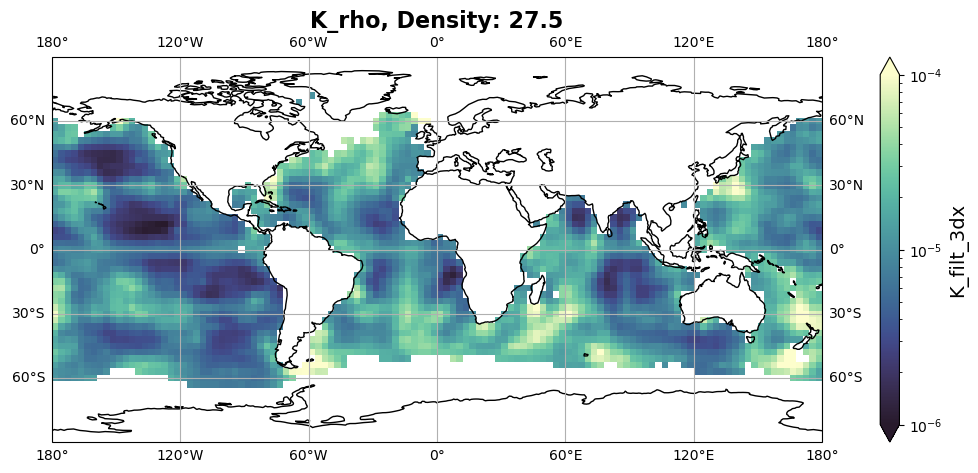

In [68]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_rho.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
ax.set_title('K_rho, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_rho_275.png', bbox_inches='tight')

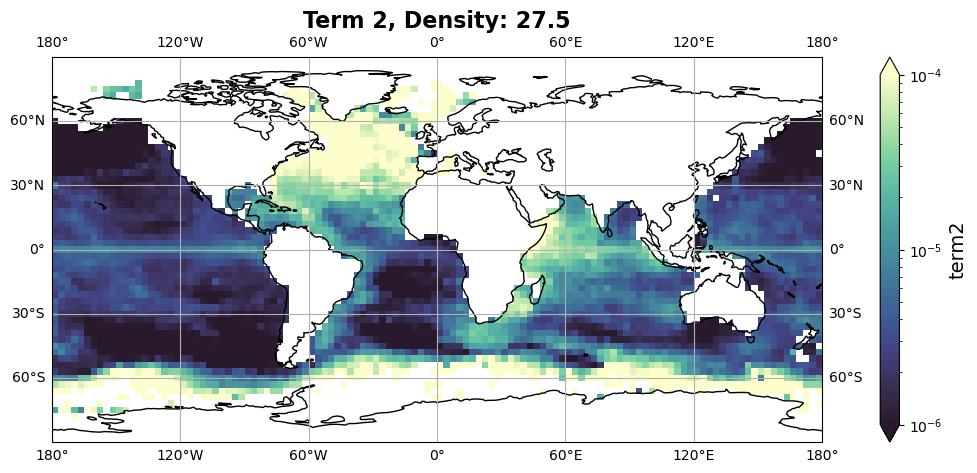

In [53]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term2.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
ax.set_title('Term 2, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term2_275.png', bbox_inches='tight')

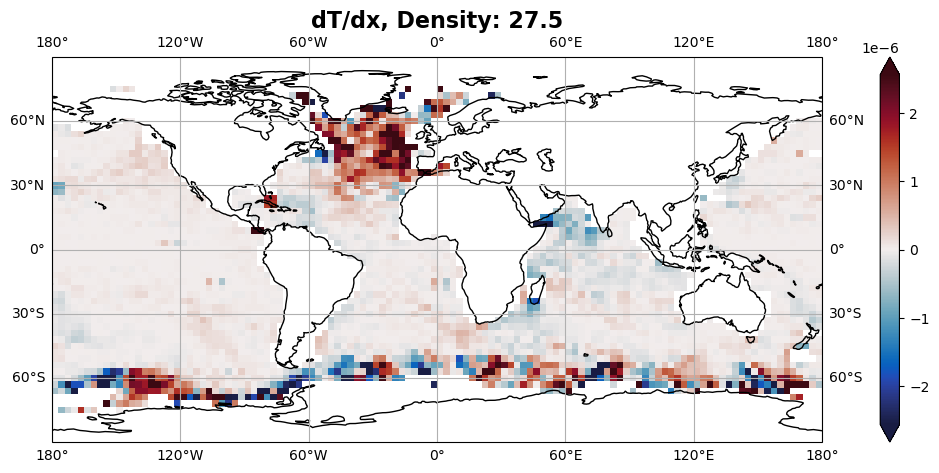

In [54]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_m_dx.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, robust=True)
ax.set_title('dT/dx, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dTdx_275.png', bbox_inches='tight')

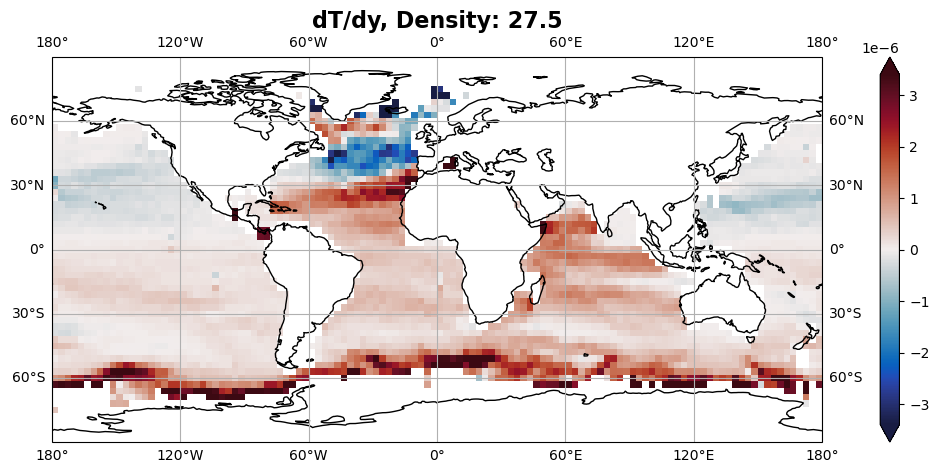

In [55]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_m_dy.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, robust=True)
ax.set_title('dT/dy, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dTdy_275.png', bbox_inches='tight')

In [56]:
dT_dx = ct_m_dx.rename('dT_dx')
dT_dy = ct_m_dy.rename('dT_dy')

In [57]:
# Choose a density slice—here using index, but you could use `.sel(density=...)` too
k = 27.5  # example index for a specific density level
u = dT_dx.sel(density=k, method='nearest')
v = dT_dy.sel(density=k, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

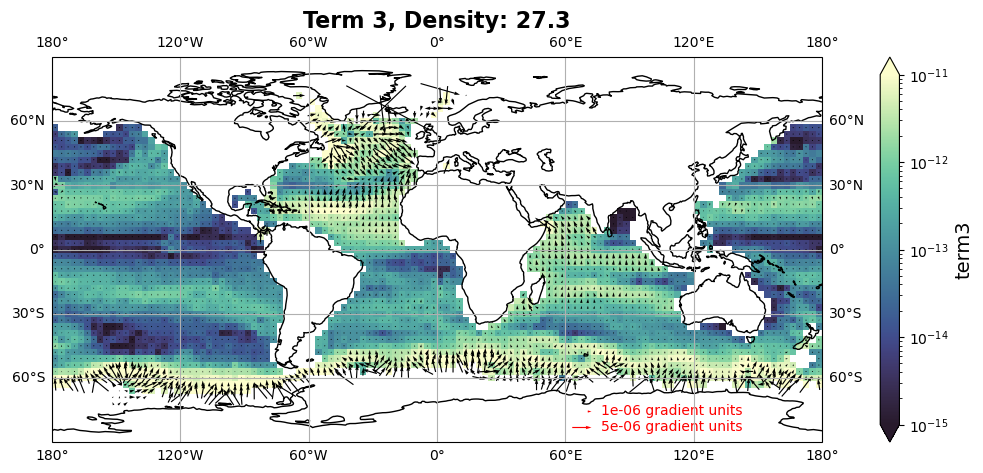

In [58]:
density = 27.3

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term3.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-15, vmax=1e-11))
q = ax.quiver(XX, YY, U, V, scale=2e-4, pivot='middle', width=0.0015)
ax.quiverkey(q, X=0.7, Y=0.08, U=1e-6, label=f'{1e-6:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.quiverkey(q, X=0.7, Y=0.04, U=5e-6, label=f'{5e-6:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.set_title('Term 3, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term3_275.png', bbox_inches='tight')

In [60]:
K_e

<xarray.Dataset> Size: 181MB
Dimensions:     (lon: 120, lat: 59, density: 3200)
Coordinates:
  * lon         (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat         (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 81.0 84.0 87.0
  * density     (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
Data variables:
    K_filt_3dx  (density, lon, lat) float64 181MB nan nan nan ... nan nan nan

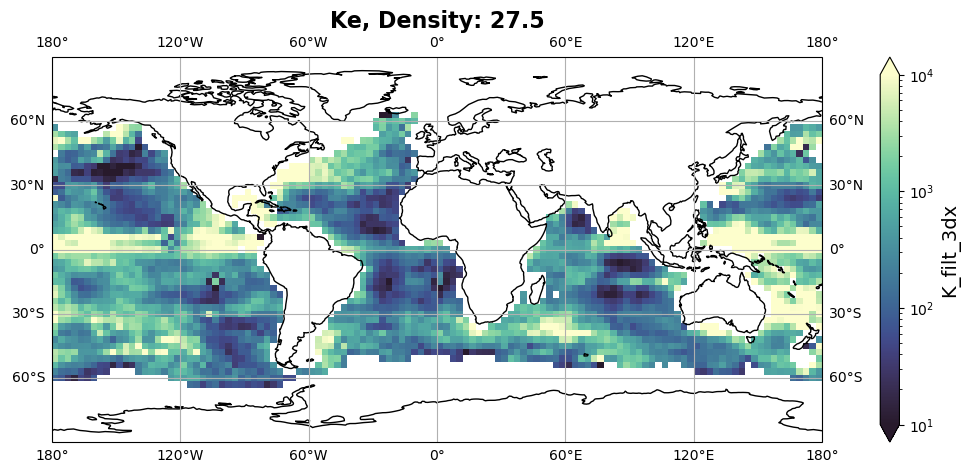

In [67]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_e.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
ax.set_title('Ke, Density: {}'.format(np.round(K_e.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_e_275.png', bbox_inches='tight')

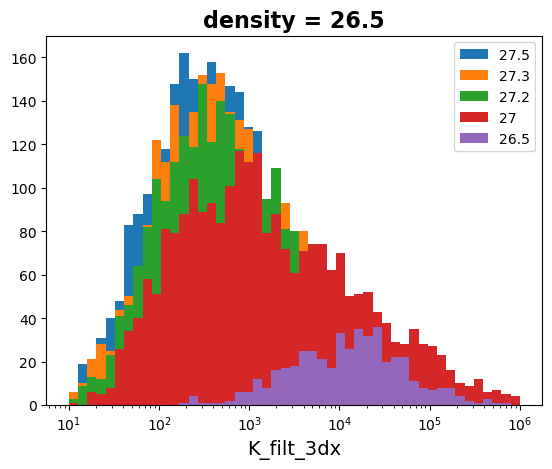

In [69]:
K_e.sel(density=27.5, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27.5)
K_e.sel(density=27.3, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27.3)
K_e.sel(density=27.2, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27.2)
K_e.sel(density=27, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27)
K_e.sel(density=26.5, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=26.5)
plt.legend()
plt.xscale('log');

## Average Isopycnal Depth

In [22]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_rho.nc')

In [44]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        #print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [34]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    pmean_smooth = ds_rho.PRES.mean('N_PROF').rolling(density=roll, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[['density'], ['density']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF','pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'N_PROF': ds_rho.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(lat = ('N_PROF', ds_rho.lat.data))
    ds_pmean = ds_pmean.assign_coords(lon = ('N_PROF', ds_rho.lon.data))
    
    return ds_pmean

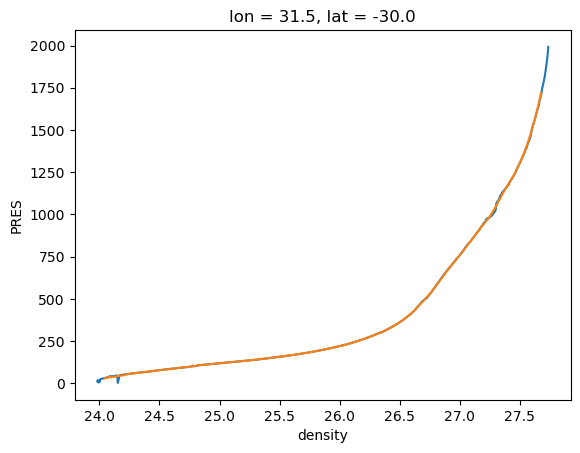

In [98]:
lon, lat = 30, -30
roll=50
ds_rho.PRES.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').plot()
ds_rho.PRES.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').rolling(density=roll, center=True).mean().plot()

In [40]:
K_e['PRES'] = (('density','lon','lat'), ds_rho.PRES.data)

In [41]:
K_e_N_PROF = K_e.stack(N_PROF=('lon','lat'))
K_e_N_PROF = K_e_N_PROF.reset_index('N_PROF')
K_e_N_PROF = K_e_N_PROF.assign_coords(lon = ('N_PROF', K_e_N_PROF.lon.data),
                                      lat = ('N_PROF', K_e_N_PROF.lat.data))

In [45]:
testing = get_ds_pmean(K_e_N_PROF, np.linspace(0,2001,1001), ['K_e','PRES'], roll=150)

Completed comp for K_e
Completed K_e
Completed comp for PRES
Completed PRES
Completed merge


In [53]:
K_e_pmean = testing.set_index(N_PROF=['lat', 'lon']).unstack('N_PROF')

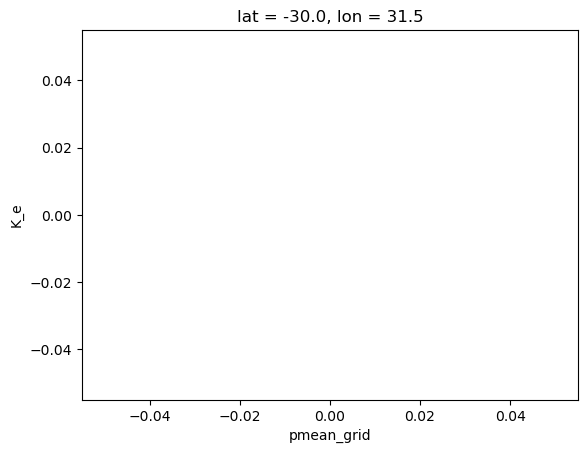

In [99]:
K_e_pmean.K_e.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').plot()

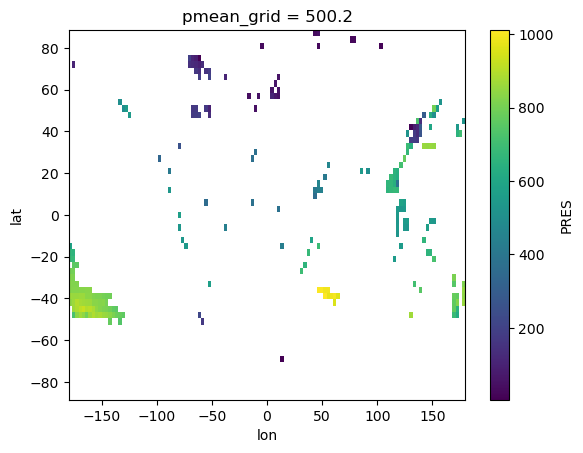

In [92]:
K_e_pmean.PRES.sel(pmean_grid=500, method='nearest').plot(x='lon',y='lat')
plt.plot(lon,lat,markersize=5,color='r')